In [1]:
# Kütüphaneler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
# 1. Veri setini yükle ve gereksiz sütunları at
df = pd.read_csv('BreastCancer.csv')
df = df.drop(['id', 'Unnamed: 32'], axis=1)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})


In [4]:
# 2. Özellikler ve hedefi ayır
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [5]:
# 3. Eğitim-test bölmesi (20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# 4. Özellikleri ölçekle (Standardizasyon)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
# 5. Model nesnelerini oluştur
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

In [8]:
# 6. Her model için tahmin yap ve metrikleri hesapla
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    results[name] = {
        "y_pred": y_pred,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm,
        "tp": tp,
        "fp": fp,
        "tn": tn,
        "fn": fn
    }

In [9]:
# 7. Soft Voting modeli
soft_voting_clf = VotingClassifier(
    estimators=[
        ('lr', models["Logistic Regression"]),
        ('dt', models["Decision Tree"]),
        ('knn', models["KNN"])
    ],
    voting='soft'
)
soft_voting_clf.fit(X_train_scaled, y_train)
y_pred_soft = soft_voting_clf.predict(X_test_scaled)

acc_s = accuracy_score(y_test, y_pred_soft)
prec_s = precision_score(y_test, y_pred_soft)
rec_s = recall_score(y_test, y_pred_soft)
f1_s = f1_score(y_test, y_pred_soft)
cm_s = confusion_matrix(y_test, y_pred_soft)
tn_s, fp_s, fn_s, tp_s = cm_s.ravel()

results["Soft Voting"] = {
    "y_pred": y_pred_soft,
    "accuracy": acc_s,
    "precision": prec_s,
    "recall": rec_s,
    "f1": f1_s,
    "confusion_matrix": cm_s,
    "tp": tp_s,
    "fp": fp_s,
    "tn": tn_s,
    "fn": fn_s
}

,Accuracy,Precision,Recall,F1 Score,TP,FP,TN,FN
Logistic Regression,0.973684,0.976190,0.953488,0.964706,41.0,1.0,70.0,2.0
Decision Tree,0.947368,0.930233,0.930233,0.930233,40.0,3.0,68.0,3.0
KNN,0.947368,0.930233,0.930233,0.930233,40.0,3.0,68.0,3.0
Soft Voting,0.973684,0.976190,0.953488,0.964706,41.0,1.0,70.0,2.0


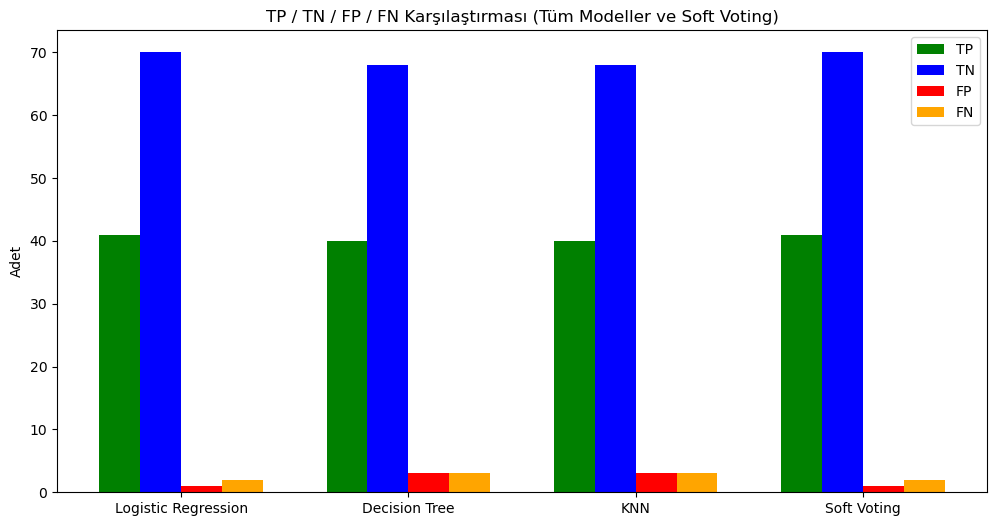

In [11]:
# 8. Sonuçları tablo halinde göster
metrics_table = pd.DataFrame({
    model: {
        'Accuracy': results[model]['accuracy'],
        'Precision': results[model]['precision'],
        'Recall': results[model]['recall'],
        'F1 Score': results[model]['f1'],
        'TP': results[model]['tp'],
        'FP': results[model]['fp'],
        'TN': results[model]['tn'],
        'FN': results[model]['fn'],
    }
    for model in results
}).T

display(metrics_table)

# 9. TP, TN, FP, FN değerlerini bar grafikte göster
labels = list(results.keys())
tps = [results[m]['tp'] for m in labels]
fps = [results[m]['fp'] for m in labels]
tns = [results[m]['tn'] for m in labels]
fns = [results[m]['fn'] for m in labels]

plt.figure(figsize=(12,6))
x = np.arange(len(labels))
width = 0.18

plt.bar(x - 1.5*width, tps, width, label='TP', color='green')
plt.bar(x - 0.5*width, tns, width, label='TN', color='blue')
plt.bar(x + 0.5*width, fps, width, label='FP', color='red')
plt.bar(x + 1.5*width, fns, width, label='FN', color='orange')

plt.xticks(x, labels)
plt.ylabel("Adet")
plt.title("TP / TN / FP / FN Karşılaştırması (Tüm Modeller ve Soft Voting)")
plt.legend()
plt.show()


In [ ]:
# 10. Confusion Matrix görselleştirme (her model için)
for model in results:
    plt.figure()
    cm = results[model]['confusion_matrix']
    plt.imshow(cm, cmap='Blues')
    plt.title(f'{model} - Confusion Matrix')
    plt.xlabel('Tahmin')
    plt.ylabel('Gerçek')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.show()